<a href="https://colab.research.google.com/github/sahils2607/Some_pytorch_projects/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import numpy as np
import pandas as pd
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import transforms,models
import torch.nn.functional as F
import torch.nn as nn



In [3]:
vgg19 = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [5]:
for params in vgg19.parameters():
  params.requires_grad_(False)


In [6]:
for tensor in vgg19.state_dict():
  print(tensor,'\t',vgg19.state_dict()[tensor].size())

0.weight 	 torch.Size([64, 3, 3, 3])
0.bias 	 torch.Size([64])
2.weight 	 torch.Size([64, 64, 3, 3])
2.bias 	 torch.Size([64])
5.weight 	 torch.Size([128, 64, 3, 3])
5.bias 	 torch.Size([128])
7.weight 	 torch.Size([128, 128, 3, 3])
7.bias 	 torch.Size([128])
10.weight 	 torch.Size([256, 128, 3, 3])
10.bias 	 torch.Size([256])
12.weight 	 torch.Size([256, 256, 3, 3])
12.bias 	 torch.Size([256])
14.weight 	 torch.Size([256, 256, 3, 3])
14.bias 	 torch.Size([256])
16.weight 	 torch.Size([256, 256, 3, 3])
16.bias 	 torch.Size([256])
19.weight 	 torch.Size([512, 256, 3, 3])
19.bias 	 torch.Size([512])
21.weight 	 torch.Size([512, 512, 3, 3])
21.bias 	 torch.Size([512])
23.weight 	 torch.Size([512, 512, 3, 3])
23.bias 	 torch.Size([512])
25.weight 	 torch.Size([512, 512, 3, 3])
25.bias 	 torch.Size([512])
28.weight 	 torch.Size([512, 512, 3, 3])
28.bias 	 torch.Size([512])
30.weight 	 torch.Size([512, 512, 3, 3])
30.bias 	 torch.Size([512])
32.weight 	 torch.Size([512, 512, 3, 3])
32.bias 	

In [36]:
print(vgg19)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(device) 

cuda


In [9]:
vgg19.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# **Loading the content and style image**

In [15]:
#This function converts images to normalized tensors
def load_image(img_path,max_size=512,shape=None):
  if "http" in img_path:
    response=request.get(img_path)
    image=Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image=Image.open(img_path).convert('RGB')
  size=max_size
  if shape is not None:
    size=shape
  in_transforms=transforms.Compose(
      [
       transforms.Resize(size),
       transforms.ToTensor(),
       transforms.Normalize( (0.485,0.456,0.406),(0.229,0.224,0.225))
      ]
   )
  image=in_transforms(image)[:3,:,:].unsqueeze(0)
  return image

        

In [16]:
content=load_image('/content/drive/My Drive/amsterdam-01.jpg').to(device)
style=load_image('/content/drive/My Drive/1280px-van-gogh-starry-night-google-art-project.jpg',shape=content.shape[-2:]).to(device)

In [17]:
print(type(content),content.shape)
print(type(style),style.shape)

<class 'torch.Tensor'> torch.Size([1, 3, 512, 910])
<class 'torch.Tensor'> torch.Size([1, 3, 512, 910])


In [21]:
#to unnormalize an image and convert to tensor image to numpy image to display
def im_conversion(tensor):
  image=tensor.to('cpu').clone().detach()
  image=image.numpy().squeeze() ## removes the batch dimension
  image=image.transpose(1,2,0)
  image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
  image=image.clip(0,1)

  return image


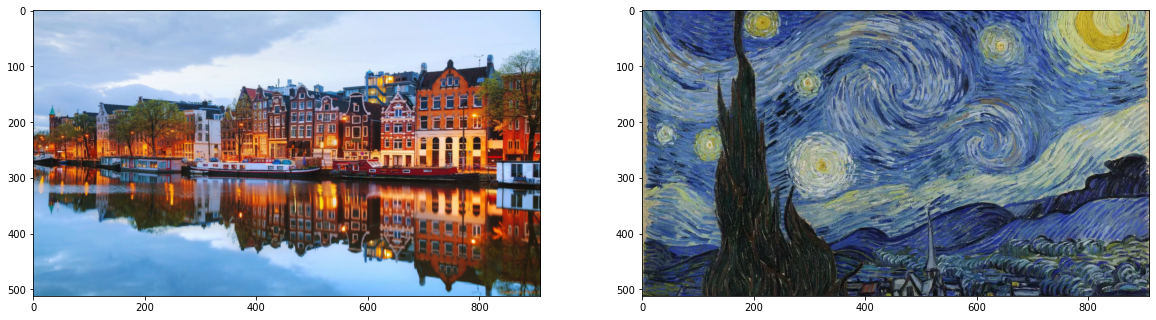

In [22]:


# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_conversion(content))
ax2.imshow(im_conversion(style))



# **Content and style features**

In [ ]:
def get_features(images,models,layers=None):
  if layers is None:
    layers={'0':'conv1_1',
            }


# **Gram Matrix**

In [50]:
def gram_matrix(tensor):
  batch_size,d,h,w=tensor.size()
  #tensor=tensor.squeeze(0)
  tensor=tensor.reshape(d,h*w)
  tensor1=torch.transpose(tensor,1,0)
  #print(tensor)
  gram=torch.mm(tensor,tensor1)
  return gram

In [51]:
z1=torch.rand([1,3,4,4])
print(z1)
z1=gram_matrix(z1)
print(z1.shape)

print(z1)

tensor([[[[0.0486, 0.1138, 0.7258, 0.5899],
          [0.0337, 0.4296, 0.6452, 0.7634],
          [0.9026, 0.9886, 0.8628, 0.9549],
          [0.9354, 0.4695, 0.8718, 0.9428]],

         [[0.6916, 0.2002, 0.8176, 0.2306],
          [0.0290, 0.3492, 0.9346, 0.7182],
          [0.2258, 0.1514, 0.6608, 0.4925],
          [0.0467, 0.8681, 0.4203, 0.4304]],

         [[0.6657, 0.3943, 0.7245, 0.6984],
          [0.1153, 0.8882, 0.5779, 0.7997],
          [0.3784, 0.5717, 0.0567, 0.6924],
          [0.2748, 0.3712, 0.9772, 0.8821]]]])
torch.Size([3, 3])
tensor([[8.2676, 4.7055, 6.1157],
        [4.7055, 4.6230, 4.3967],
        [6.1157, 4.3967, 6.2862]])


In [52]:
def get_features(image,model,layers=None):
  if layers is None:
    layers={'0':'conv1_1',
            '5': 'conv2_1', 
            '10': 'conv3_1', 
             '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'
            }
  features={}
  x=image
  for name,layer in model._modules.items():
      x=layer(x)
      if name in layers:
        features[layers[name]]=x

  return features  


In [53]:
content_features=get_features(content,vgg19)
style_features=get_features(style,vgg19)
style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target=content.clone().requires_grad_(True).to(device)


**Content and style weights**

In [58]:
style_weights={
    'conv1_1':1.,
    'conv2_1':0.8,
    'conv3_1':0.5,
    'conv4_1':0.3,
     'conv5_1':0.1
    }
content_weight=1
style_weight=4e7

# **Updating the target and Calculating losses**

In [55]:
def content_loss(tensor1,tensor2):
  return torch.mean((tensor1['conv4_2']-tensor2['conv4_2'])**2)

Total_ loss 17928500.0


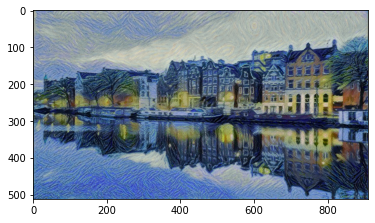

Total_ loss 6341747.0


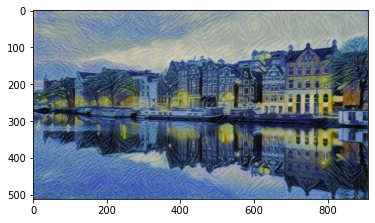

Total_ loss 3522635.25


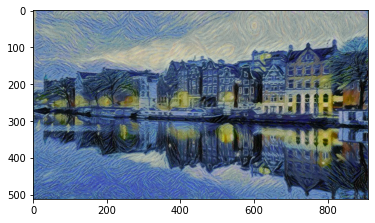

Total_ loss 2398287.25


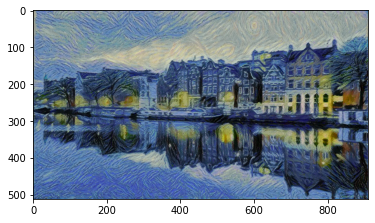

Total_ loss 1827824.125


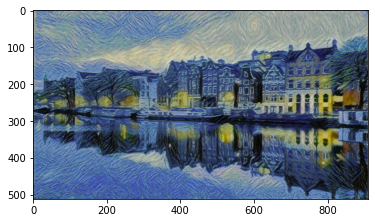

In [59]:
show_every=400

optimizer=optim.Adam([target],lr=0.003)
iterations=2001

for iteration in range(1,iterations):
  target_features=get_features(target,vgg19)
  content_loss_val=content_loss(target_features,content_features)

  style_loss=0
  for layer in style_weights:
    target_feature=target_features[layer]
    _,d,h,w=target_feature.shape
    target_gram=gram_matrix(target_feature)
    style_grami=style_gram[layer]
    layer_style_loss=style_weights[layer]*torch.mean((target_gram-style_grami)**2)
    style_loss+=layer_style_loss/(d*h*w)

  total_loss=content_weight*content_loss_val+style_weight*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if iteration%show_every==0:
    print('Total_ loss',total_loss.item())
    plt.imshow(im_conversion(target))
    plt.show()



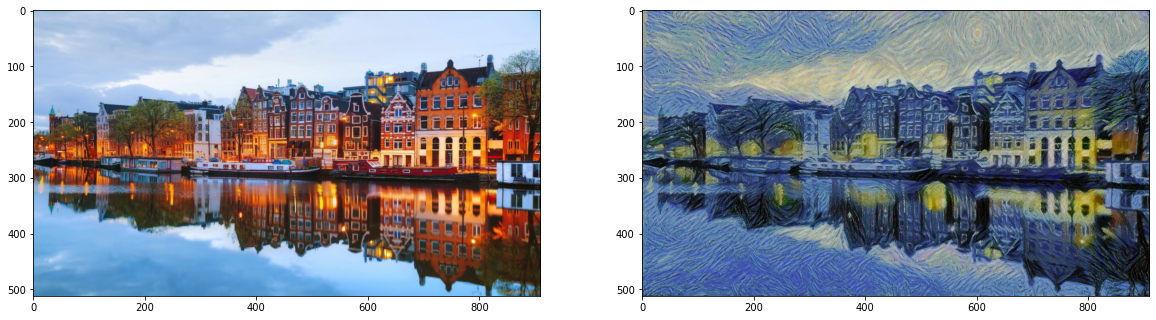

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_conversion(content))
ax2.imshow(im_conversion(target))